In [1]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [2]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()
#action space is a Box(1,) with values between [-2,2], joint effort
print(env.action_space.low)
#observation space is 3d angle of pendulum cos, sin, velocity max:1,1,8; min:-1,-1,8
print(env.observation_space.low)

[-2.]
[-1. -1. -8.]


In [3]:
#reward formular: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) (-16.27 is worst, 0 best)
print(env.reset())
a = env.action_space.sample()
print(a)
state, reward, done, info = env.step(a)
print(state, reward, done, info)

[-0.93400635 -0.35725639 -0.79730812]
[0.19525401]
[-0.95125058 -0.30841909 -1.03596232] -7.771249276302971 False {}


In [4]:
# Learning episodes
epochs = 10000

In [5]:
from Discretization import Discretization

larry = Discretization("easy", "Pendulum")

print(larry.map_to_index([1, -0.5, 6]))
print(larry.map_to_index([-1, 0, 0]))
print(larry.map_to_index([0, 0.5, -8]))

[20, 5, 14]
[0, 10, 8]
[10, 15, 0]


Regression...
...done
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


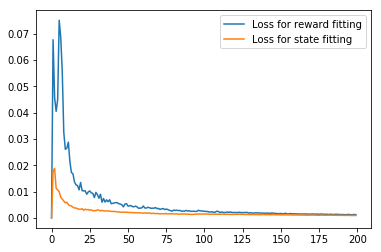

In [6]:
"""
    Regression of old state and performed action to new state and observed reward.
"""

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


rtx = []
rty = []
stx = []
sty = []
plotr = []
plots = []

regressorReward = RandomForestRegressor(n_estimators=10, min_samples_split=2)
regressorState = RandomForestRegressor(n_estimators=10, min_samples_split=2)

old_state = env.reset()

print("Regression...")
for i in range(epochs):
    
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)

    rtx.append(np.append(old_state ,action))
    rty.append(reward)
    stx.append(np.append(old_state,action))
    sty.append(next_state)
    
    if i%50==0: # 50 works nicely
        
        regressorReward.fit(rtx, rty)
        fitrtx = regressorReward.predict(rtx)
        mse = mean_squared_error(rty, fitrtx)
        plotr.append(mse)

        
        regressorState.fit(stx, sty)
        fitstx = regressorState.predict(stx)
        mse = mean_squared_error(sty, fitstx)

        plots.append(mse)
    
    old_state = np.copy(next_state)

print("...done")
plt.figure(0)
plt.plot(plotr, label="Loss for reward fitting")

plt.plot(plots, label="Loss for state fitting")
plt.legend()
print(regressorReward)

In [7]:
"""
   Value Iteration
   
"""

'\n   Value Iteration\n   \n'

In [8]:
"""
    Policy Iteration
    
    Gives convergence towards the optimal policy by iteratively
    performing Policy Evaluation and Policy Improvement

"""

def policy_iteration(disc, theta, gamma):        
    
    print("Policy iteration...")

    value_function = np.ones(shape=disc.state_space_size)
    policy = np.zeros(shape=disc.state_space_size)

    
    def policy_evaluation(theta, gamma):
        print()
        print("Evaluating policy")
        delta = theta
        while delta >= theta:
            delta = 0
            # Iteratate over discrete state space
            for s0 in disc.state_space[0]:
                for s1 in disc.state_space[1]:
                    for s2 in disc.state_space[2]:
                        
                        # Get index for state 
                        # The method already iterates over a discretized state space
                        # But the states need to get mapped to a positive index do to possible 'negative' states
                        index = disc.map_to_index([s0, s1, s2])
                        
                        v = value_function[index[0], index[1], index[2]]
                        
                        """
                         V(s) = Sum...p(s',r|s,pi(s))[r+gamma*V(s')]
                         
                        """
                        a = policy[index[0], index[1], index[2]]
                        
                        # input for regression
                        x = np.array([s0, s1, s2, a]).reshape(1, -1)
                        
                        # Predict next state and reward with regressors
                        next_s = regressorState.predict(x).T.reshape(-1,)
                        r = regressorReward.predict(x)      
                        
                        next_index = disc.map_to_index([next_s[0], next_s[1], next_s[2]])
                                          
                        value_function[index[0], index[1], index[2]] = r + gamma*value_function[next_index[0],
                                                                              next_index[1], next_index[2]]
                                          
                        delta = max(delta, v - value_function[index[0], index[1], index[2]])
            print("Delta: ", delta)
    
    
    def policy_improvement(gamma):
        print()
        print("Improving policy")
        policy_stable = True
        for s0 in disc.state_space[0]:
                for s1 in disc.state_space[1]:
                    for s2 in disc.state_space[2]:
                        
                        # Indexing
                        index = disc.map_to_index([s0, s1, s2])
                        
                        old_action = policy[index[0], index[1], index[2]]
                        
                        """
                            pi(s) = argmax_a ... 
                            We do not have to care about the prob. distribution,
                            as we have a deterministic env.
                            
                        """
                        # Iterate over all actions and get the one with max. expected reward
                        amax = 2
                        rmax = -100
                        for a in disc.action_space:
                            x = np.array([s0, s1, s2, a])
                            x = x.reshape(1,-1)
                            next_s = regressorState.predict(x).T.reshape(-1,)
                            next_index = disc.map_to_index([next_s[0], next_s[1], next_s[2]])
                            r = regressorReward.predict(x)
                            expected_reward = r + gamma*value_function[next_index[0], next_index[1], next_index[2]]
                            if rmax < expected_reward:
                                amax = a
                                rmax = expected_reward 
                        policy[index[0], index[1], index[2]] = amax # TODO
                        
                        if old_action != policy[index[0], index[1], index[2]]:
                            policy_stable = False
                            
        print("Policy stable: ", policy_stable)
        return policy_stable
        
    # Run until policy is stable
    stable_policy = False
    while not stable_policy:
        policy_evaluation(theta, gamma)
        stable_policy = policy_improvement(gamma)
    
    print()
    print("...done")
    return value_function, policy
    
value_function, policy = policy_iteration(larry, theta=1, gamma=0.1)


Policy iteration...

Evaluating policy
Delta:  18.846694942343333
Delta:  1.7062556276777379
Delta:  0.17062556276777308

Improving policy
Policy stable:  False

Evaluating policy
Delta:  0.010785660383248796

Improving policy
Policy stable:  False

Evaluating policy
Delta:  0.0010785660383234585

Improving policy
Policy stable:  False

Evaluating policy
Delta:  0.0001078566038330564

Improving policy
Policy stable:  False

Evaluating policy
Delta:  1.0193819765191847e-05

Improving policy
Policy stable:  True

...done


[-2.]
[-2.]
[-2.]
[0.5]
[0.]
[0.5]
[1.5]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[1.5]
[-2.]
[-1.]
[1.5]
[0.5]
[-2.]
[-2.]
[2.]
[1.]
[1.]
[-1.5]
[-1.5]
[0.5]
[-1.]
[-2.]
[2.]
[0.5]
[-0.5]
[-0.5]
[1.]
[-2.]
[0.]
[-1.5]
[-0.5]
[-0.5]
[0.]
[-2.]
[-1.]
[1.5]
[2.]
[1.]
[2.]
[-2.]
[-2.]
[-2.]
[1.5]
[-2.]
[-1.]
[1.5]
[0.5]
[2.]
[-2.]
[-1.5]
[2.]
[1.]
[1.]
[-1.5]
[-1.]
[0.5]
[-1.]
[-2.]
[2.]
[2.]
[-0.5]
[-0.5]
[-2.]
[-2.]
[-1.5]
[1.]
[1.]
[1.5]
[1.5]
[1.5]
[1.5]
[2.]
[-2.]
[2.]
[-2.]
[-2.]
[-2.]
[1.5]
[2.]
[-2.]
[-2.]
[2.]
[1.]
[1.]
[-0.5]
[-0.5]
[2.]
[-2.]
[2.]
[-1.]
[0.]
[-1.]
[2.]
[2.]
[0.5]
[-0.5]
[-0.5]
[1.]
[-2.]
[0.]
[-1.5]
[1.5]
[-0.5]
[-0.5]
[-1.]
[-2.]
[2.]
[1.]
[-2.]
[2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[0.5]
[0.5]
[0.5]
[-2.]
[2.]
[2.]
[0.5]
[0.5]
[0.5]
[-2.]
[-2.]
[-2.]
[1.]
[0.5]
[1.5]
[1.5]
[-2.]
[-2.]
[-0.5]
[1.]
[2.]
[2.]
[2.]
[-1.]
[-0.5]
[-0.5]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[1.5]
[-2.]
[-2.]
[-0.5]
[-0.5]
[-0.5]
[2.]
[2.]
[2.]


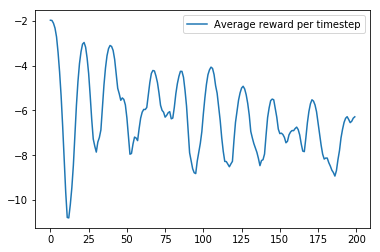

In [11]:
"""
    Some stuff to see the predictions, discretizations and learned functions in action

"""
rewards_per_episode = []

for e in range(5):
    
    # Discretize first state
    index = larry.map_to_index(env.reset())
    
    rewards_per_timestep = []
    
    for t in range(1000):
        # Render environment
        # env.render()

        # Do step according to policy and get observation and reward
        action = np.array([policy[index[0], index[1], index[2]]])
        print(action)
        #action = env.action_space.sample()
        observation, reward, done, info = env.step(action)

        rewards_per_timestep.append(reward)
        
        # Discretize observed state
        index = larry.map_to_index(observation)

        if done:
            print("Episode {} finished after {} timesteps".format(e+1, t+1))
            break
    
    rewards_per_episode.append(rewards_per_timestep)

# Average reward over episodes
rewards = np.average(rewards_per_episode, axis=0)
print(np.shape(rewards))
        
env.close()

# Plot rewards per timestep averaged over episodes
plt.figure()
plt.plot(rewards, label='Average reward per timestep')
plt.legend()
plt.show()